# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import lines
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [13]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Utente\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


So, we have 2 dataset with (almost) the same structure. There focus of the population dataset, trying to clean it.  
Considering that most of the features are in common with the second dataset, it will be nice to build some cleaning functions that would then be used also on the other dataset.

**TO DO LIST**:  
This is how we will proceed in this first part, cleaning and processing these data to accomplish the requested goal:
- Dropping useless features
- Handling missing values
- Cleaning features
- Pre-processing features (like creating dummies, converting datatypes or other transformations)
- Feature scaling (because the new dummies are all 0/1 features, but numerical features have probably a different scale)
- Feature selections (here we'll probably apply a PCA, to clean out the noise and reducing the size of the dataset, preserving most of the informations)
- Apply a clustering model

### Dropping features
The first thing I would do, considering the work we are doing, is to soon drop all the features which cannot be useful anyway, like forse example addresses, CAP/ZIP codes and other useless features for our purpose. This first step is based on the documentations, where to find the meaning of all the columns of the dataset, from which I identified the following features to drop:  

PLZ -->  postcode

I didnt found this column in the dataset, but in case I would have drop it.

In [10]:
# dropping useless columns
try:
    azdias.drop('PLZ', axis=1, inplace=True)
except KeyError:
    print('Feature "PLZ" not found.')

Feature "PLZ" not found.


### Missing values
Let's begin investigating missing values. Looking at the documentation, the missing values are often saven as zeros, -1 or other character, which is not so good for us, because in order to work correctely with the data, we must indentify and convert all these values as **NA** values.  

Then we will look at these values, where are they and how many they are, to decide how to handle them. For example, if they were concentrated on just few variables, it would be better to drop those variable, ontherwise if they are randomly distributed among the features, we could decide to drop the rows, if they are few, or to try filling them in some way if they are many, or also keep them if the variables will be later transformed into dummies. Or more than one of these.  

Let's look for example at the feature "CAMEO_DEUG_2015". The documentation says that this feature can have integer values between 1 and 9 as domain, plus the value -1 for missing values, let's verify it:

In [6]:
azdias['CAMEO_DEUG_2015'].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

So, it seems the documentation is not suficient, because we haven't "-1", but we have NAs and also "X", which could be another NA, without other informations. Furthermore, the other values seems to be either integers, either floats, either strings.

So, if the documentation is not consistent with the actual data, we could check every single feature to verify if it requires some cleaning, or we can use some euristic to clean less precisly but more quickly this dataset.

We will follow the second road here.

Considering the high number of variables in this dataset, with different dominiums and NA encodings, the fastest way we can handle NA and in the same time the cleaning phase is considering all of them (a part from numerical features) as dummies. NAs are considered as a separate column, keeping this way the information of having a NA as a value on its own.  
Proceeding this way, we have two main disadvantages:
-  The number of columns will increase notably.
-  The sorting informations for ordinal features (the great part of this dataset) is lost.

Concernirn the first problem, we can handle it later performing a PCA on the entire dataset, remving also a lot of noise from the data.  
For the second problem, we must consider that, yes, we are loosing some informations, but also that keeping those informations would have had another cost, which is the assumption of equal distances between every two ticks on the scale used, because the features would have treated as numerical this way, and we can't assure that this assumption is reasonably true for most or all these features, so removing these informations keeps also us safe from wrong assumptions on data, which is a risk when not properly verified.

Let's first try to split the features (lloking at the documentation) between numerical and not numerical, which will be transformed into dummies.

In [3]:
numeric_vars = [
    'ANZ_HAUSHALTE_AKTIV',
    'ANZ_HH_TITEL',
    'ANZ_PERSONEN',
    'ANZ_TITEL',
    'MIN_GEBAEUDEJAHR'
]

dummie_vars = list(set(azdias.columns).difference(numeric_vars))

Before of creating the dummies variables, we need to do another check, to ensure that our classification is correct before proceeding. Assuming a categorical variables should have just a few possible values, let's search the dataset for variables with a high number of possibile outcomes, becasuse probably they are numerical features, of if they are actually categorical, we should decide if keeping them or not, because creating a high number of variables is computational expensive, and the gain in information could be poor. An euristic we could use, is cases like this, is to verify if the values are well distributed among the possibilities or very concentrated just on some of them, because a high concentrated distribution gives poor information and can be easily removed.

In [16]:
# check for variables which a high number of possible values
for i, col in enumerate(azdias.columns):
    if col in dummie_vars:
        n = len(azdias[col].unique())
        if n > 20:
            print(f'[{i}] {col} ({n} unique values)')

[0] LNR (891221 unique values)
[3] ALTER_HH (23 unique values)
[8] ALTERSKATEGORIE_FEIN (27 unique values)
[13] ANZ_STATISTISCHE_HAUSHALTE (269 unique values)
[17] CAMEO_DEU_2015 (46 unique values)
[19] CAMEO_INTL_2015 (44 unique values)
[61] D19_LETZTER_KAUF_BRANCHE (36 unique values)
[97] EINGEFUEGT_AM (5163 unique values)
[98] EINGEZOGENAM_HH_JAHR (38 unique values)
[100] EXTSEL992 (57 unique values)
[111] GEBURTSJAHR (117 unique values)
[192] KBA13_ANZAHL_PKW (1262 unique values)
[307] LP_LEBENSPHASE_FEIN (42 unique values)
[353] VERDICHTUNGSRAUM (47 unique values)


The following variables are not found in the documentation and will be removed, because we don't know what they mean, anyway.

LNR  
ANZ_STATISTISCHE_HAUSHALTE  
D19_LETZTER_KAUF_BRANCHE  
EINGEFUEGT_AM  
EINGEZOGENAM_HH_JAHR  
EXTSEL992  
ALTERSKATEGORIE_FEIN  
VERDICHTUNGSRAUM

In [13]:
# this feature has a very high number of possible outcomes, but they are well distributed, so by now we will keep it
azdias.D19_LETZTER_KAUF_BRANCHE.value_counts()

D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTEN                  1646
D19_BANKEN

In [18]:
# this feature has a very high number of possible outcomes, but they are well distributed, so by now we will keep it
azdias.CAMEO_DEU_2015.value_counts()

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64

In [19]:
# this feature has a very high number of possible outcomes, but they are well distributed, so by now we will keep it
azdias.CAMEO_INTL_2015.value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

In [20]:
# this feature is numerical
azdias.GEBURTSJAHR.head(10)

0       0
1    1996
2    1979
3    1957
4    1963
5    1943
6       0
7    1964
8    1974
9    1975
Name: GEBURTSJAHR, dtype: int64

In [21]:
# this feature is numerical
azdias.KBA13_ANZAHL_PKW.head(10)

0       NaN
1     963.0
2     712.0
3     596.0
4     435.0
5    1300.0
6     867.0
7     758.0
8     511.0
9     530.0
Name: KBA13_ANZAHL_PKW, dtype: float64

Now, we'll handle thiese variables as said here above:

In [3]:
numeric_vars = [
    'ANZ_HAUSHALTE_AKTIV',
    'ANZ_HH_TITEL',
    'ANZ_PERSONEN',
    'ANZ_TITEL',
    'MIN_GEBAEUDEJAHR',
    'GEBURTSJAHR',
    'KBA13_ANZAHL_PKW'
]

exclude_vars = [
    'LNR', # not in documentation
    'STATISTISCHE_HAUSHAL', # not in documentation
    'D19_LETZTER_KAUF_BRANCHE', # not in documentation
    'EINGEFUEGT_AM', # not in documentation
    'EINGEZOGENAM_HH_JAHR', # not in documentation
    'EXTSEL992', # not in documentation
    'ALTERSKATEGORIE_FEIN', # not in documentation
    'VERDICHTUNGSRAUM', # not in documentation
    'ANZ_STATISTISCHE_HAUSHALTE' # not in documentation
]

dummie_vars = list(set(azdias.columns).difference(numeric_vars).difference(exclude_vars))

Now we can proceed to transform the categoriacal features in dummies

### Cleaning feature

#### Dummies

This is an example of how the new dataset will be alike.

In [26]:
pd.get_dummies(azdias[dummie_vars[0]].astype('category'), dummy_na=True, drop_first=False).head()

,1.0,2.0,3.0,4.0,5.0,NaN
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,1,0,0,0,0,0


Let's clean the entire dataset.

In [4]:
# function which performs these cleaning steps

def step1_drop_and_dummies(df):
    
    n_cols = df.shape[1]
    
    # drop features to be excluded (defined above)
    for feat in exclude_vars:
        try:
            df.drop(feat, axis=1, inplace=True)
        except KeyError:
            print(f'Feature "{feat}" not found in columns!')

    # substituting the categorical varibles with dummy columns for every possible value
    print('\nOriginal number of columns:', n_cols)
    df = pd.concat(
        [
            df,
           pd.get_dummies(df[dummie_vars].astype('category'), dummy_na=True, drop_first=False)
        ], axis=1).drop(dummie_vars, axis=1)
    print('New number of columns:', df.shape[1])
    
    return df

In [14]:
azdias = step1_drop_and_dummies(azdias)

Feature "STATISTISCHE_HAUSHAL" not found in columns!

Original number of columns: 366
New number of columns: 2685


#### Handling last NAs

Now, let's finish our cleaning procedure dropping all the features with too much NAs before going on:

In [21]:
# features with more than 10% of missign values
azdias.columns[azdias.isna().sum() / azdias.shape[0] > 0.1]

Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW',
       'MIN_GEBAEUDEJAHR'],
      dtype='object')

In [15]:
# features with more than 10% of missign values
azdias.drop(azdias.columns[azdias.isna().sum() / azdias.shape[0] > 0.1], axis=1, inplace=True)

Now, check for other NAs

In [10]:
# features with more than 30% of missign values
azdias.columns[azdias.isna().sum() > 0]

Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'],
      dtype='object')

These are all numerical features, so we can fill these NAs with the mean of each column, for example, like we'll do:

In [16]:
# filling NAs with the mean for the numeric variables with missing values
cols = azdias.columns[azdias.isna().sum() > 0]
azdias.loc[:, cols] = azdias[cols].fillna(azdias[cols].mean())

### Feature scaling

I don't use the StandardScaler of sci-kit learn and I don't process the entire dataset, either, because of memory issues.

The first approach to this task would be to transform the entire dataset, and it's basically correct, but also inefficient considering the size of our data:

In [5]:
# DEPRECATED VERSION
# standardize the dataset, to scale all the features at the same variance
for i, col in enumerate(azdias):
    azdias.loc[:, col] = (azdias.loc[:, col] - azdias.loc[:, col].mean()) / azdias.loc[:, col].std()
    if i % 200 == 0:
        print(f'{i} / 2961 processed')

0 / 2961 processed
200 / 2961 processed


KeyboardInterrupt: 

The second approach is mush smart. Considering all our dummies are 0/1, they are all on the same scale and in the range [0, 1], so we could simply put the other variables on the same range, normalizing them:

In [17]:
# remove from numeric_vars features dropped from the dataset
numeric_vars = list(set(numeric_vars).intersection(azdias.columns))

# normalize the numeric features, to put all the features in the range [0, 1]
azdias.loc[:, numeric_vars] = (azdias.loc[:, numeric_vars].max() - azdias.loc[:, numeric_vars]) /\
                              (azdias.loc[:, numeric_vars].max() - azdias.loc[:, numeric_vars].min())

### Feature extraction

Le't try to apply PCA to reduce the dimensionality or our dataset and to remove the noise from the signal at the same time

In [12]:
pca = PCA()
azdias_pca = pca.fit_transform(azdias)

MemoryError: Unable to allocate 19.6 GiB for an array with shape (2954, 891221) and data type float64

Unfortunately, this process is too memory-intensive and we cannot proceed, al least not before solving a problem. We need another way.  
Considering PCA would have helped us to decide which features were more relevant (the ones strongly related the the first principal components), we could think to perform a PCA analysis on just half of the dataset, randomly choosed, and use this model to choose the less usefull features and exclude them, then we could perform another PCA on the new, reduced dataset.

In [20]:
# creating partial PCA model (the percentage here depends on the power of the machine on which you run this analysis. Here 30% is the limit)
pca = PCA()
pca.fit(azdias.sample(frac=0.3))

PCA()

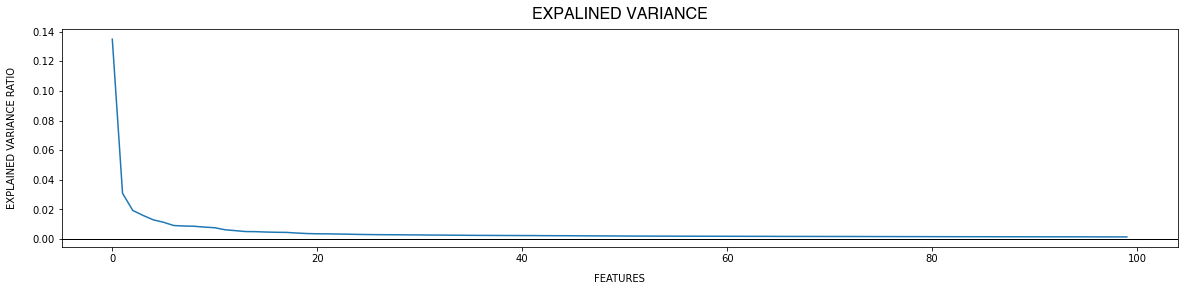

In [18]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(100), pca.explained_variance_ratio_[:100])
ax.axhline(0, color='k', lw=1)
ax.set_title('EXPALINED VARIANCE', y=1.02, size=16, fontweight='bold', fontdict={'family': 'Helvetica'})
ax.set_xlabel('FEATURES', labelpad=10, size=10)
ax.set_ylabel('EXPLAINED VARIANCE RATIO', labelpad=15, size=10)
plt.show()

The result above is the result a _partial_ dataset, but still can tell us a lot about the principal components (under the assumption that our subsample was representative of the entire dataset, but is was sampled randomly so we say that quite safely).  
Now we want to choose what **features** to take an what not, to reduce the size of the dataset, and one approach we could take is the following:  
- Looking at the plot above, we can look at the first 50 principal components, which contain the most of the variance of the entire dataset. This number is chosen arbitrarly, one can also decide to keep 100 components or also 20. It's just a trade-off between informations lost and memory usage, the more the information kept, the more the necessary memory (and computational power).
- For every component kept, we'll look at the first (by importance) 50 features related to that component, and keep all of them. Here, 50 is chosen arbitrarly. As before, the higher the threshold, the more the memory usage. To choose this threshold, I've used the plot below, where I show, for each on the first 50 principal components, the sorted absolute values of the coefficients associated with the features. This way, we can assume the magnitude of this coefficients as the importance of the related features, and so we can graphically "cut the plot" vertically where the importance drops down (red line in my plot), and that is the threshold.
- Remove every other feature from the dataset (all the features not strongly related to one of the first 50 principal components).

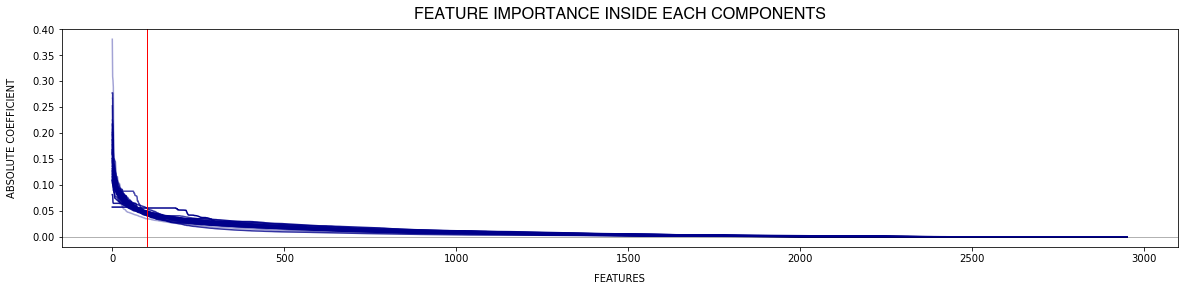

In [101]:
fig, ax = plt.subplots(figsize=(20, 4))
for i, comp in enumerate(pca.components_[:50]):
    ax.plot(np.sort(abs(comp))[::-1], alpha = 1 - i/50, color='darkblue')
ax.axhline(0, color='k', lw=1, alpha=0.3)
ax.axvline(100, color='red', lw=1, alpha=1)
ax.set_title('FEATURE IMPORTANCE INSIDE EACH COMPONENTS', y=1.02, size=16, fontweight='bold', fontdict={'family': 'Helvetica'})
ax.set_xlabel('FEATURES', labelpad=10, size=10)
ax.set_ylabel('ABSOLUTE COEFFICIENT', labelpad=15, size=10)
plt.show()

In [22]:
# algorithm to choose which features to keep
idx_feature_keep = set()
for comp in pca.components_[:50]:  # for the first 50 principal components (sorted by importance)
    for x in np.argsort(np.abs(comp))[-100:]:  # for the 50 most important features for that component (in aboslute value)
        idx_feature_keep.add(x)  # save that feature ordinal position in azdias.columns

print(f'We are keeping {len(idx_feature_keep)} features.')
print(f'We are keeping {np.round(len(idx_feature_keep) / azdias.shape[1] * 100, 1)} % af all features.')

We are keeping 1103 features.
We are keeping 41.1 % af all features.


In [23]:
features_keep = azdias.columns[list(idx_feature_keep)]

In [32]:
# remove all the other features
azdias_reducted = azdias[features_keep]

In [35]:
pca3 = PCA(n_components=50)
pca3.fit(azdias_reducted)

PCA(n_components=50)

Now, let's try to interpret at least the first principal components (later we will need this information in order to better understand the groups created when clustering data).

In [49]:
for i, comp in enumerate(pca3.components_[:5]):
    print(f'\nComponent {i}. Main features:')
    idxs = np.argsort(np.abs(comp))[::-1][:15]
    for idx in idxs:
        print(f'\t{azdias_reducted.columns[idx]} (coef: {np.round(comp[idx], 2)})')


Component 0. Main features:
	KBA05_ANTG1_nan (coef: 0.08)
	KBA05_HERST1_nan (coef: 0.08)
	KBA05_CCM2_nan (coef: 0.08)
	KBA05_KRSHERST3_nan (coef: 0.08)
	KBA05_MOD3_nan (coef: 0.08)
	KBA05_SEG9_nan (coef: 0.08)
	KBA05_SEG2_nan (coef: 0.08)
	KBA05_VORB1_nan (coef: 0.08)
	KBA05_HERST2_nan (coef: 0.08)
	KBA05_GBZ_nan (coef: 0.08)
	KBA05_SEG6_nan (coef: 0.08)
	KBA05_ALTER4_nan (coef: 0.08)
	KBA05_KW3_nan (coef: 0.08)
	MOBI_REGIO_nan (coef: 0.08)
	KBA05_MOD2_nan (coef: 0.08)

Component 1. Main features:
	MOBI_RASTER_1.0 (coef: -0.12)
	D19_VERSAND_DATUM_10.0 (coef: -0.12)
	D19_GESAMT_ANZ_24_0.0 (coef: -0.12)
	D19_GESAMT_DATUM_10.0 (coef: -0.12)
	D19_GESAMT_ONLINE_DATUM_10.0 (coef: -0.11)
	LP_STATUS_GROB_1.0 (coef: -0.11)
	D19_VERSAND_ONLINE_DATUM_10.0 (coef: -0.11)
	D19_VERSAND_ANZ_24_0.0 (coef: -0.11)
	KBA13_BAUMAX_1.0 (coef: 0.11)
	KK_KUNDENTYP_nan (coef: -0.11)
	D19_GESAMT_ANZ_12_0.0 (coef: -0.11)
	KBA05_ANTG1_0.0 (coef: -0.1)
	PLZ8_BAUMAX_1.0 (coef: 0.1)
	D19_GESAMT_OFFLINE_DATUM_10.0 (c

It's difficult to give a name to this components, but we can say:
- Component 0. It's positive joined with the NAs of many features of the KBA05 block of features (microcell data)
- Component 1. It's negatively joined with the "no transaction known" option of many financial features
- Component 2. It's very similar to component 1 (most of the features here reported cannot be found in the documentation, so it's diffifult to understand the big picture)
- Component 3. Here the values of different financial features are set to be high, so it represent a high economic power and olso an age probably high
- Component 4. This component is strongly joined with West locations and a territory (based on PLZ8) not too poor (negative correlation with lowest levels of these features.

Let's process transforming the (reduced) dataset, according the pca model we fitted before.

In [40]:
# also the transforming operation requires a lot of memory, and cannot be performed one-shot on this machine, so we will process the dataset via a mini-batch technique

# just an initizilization of the new dataset
azdias_transformed = pca3.transform(azdias_reducted.iloc[:1, :])
azdias_transformed[:0, :]

batch_n = 100000  # number of samples in a batch
n_batch = azdias_reducted.shape[0] // batch_n + 1  # number of required batches to process the entire dataset
for i in range(n_batch):
    print(f'Elaborating batch {i + 1} / {n_batch}')
    azdias_transformed = np.vstack([azdias_transformed, pca3.transform(azdias_reducted.iloc[i * batch_n : (i+1) * batch_n, :])])
print('Transformation process finished!')

Elaborating batch 1 / 9
Elaborating batch 2 / 9
Elaborating batch 3 / 9
Elaborating batch 4 / 9
Elaborating batch 5 / 9
Elaborating batch 6 / 9
Elaborating batch 7 / 9
Elaborating batch 8 / 9
Elaborating batch 9 / 9
Transformation process finished!


In [125]:
# New dataset dimensions (number of samples = all the initial ones, number of principal components = 50)
azdias_transformed.shape

(891222, 50)

## Clustering

Now that we have cleaned and pre-processed our data, it's time to search for natural clusters in these data, and for this purpose we will build a KMeans model.  
Because the _K_ number is not obvious, we have to investigate it, and we will approach this task through an _elbow plot_.

In [6]:
inertias = []
for k in range(2, 21):
    inertias.append(KMeans(n_clusters=k).fit(azdias_transformed).inertia_)
    print(f'k = {k} / 20 processed')

k = 2 / 20 processed
k = 3 / 20 processed
k = 4 / 20 processed
k = 5 / 20 processed
k = 6 / 20 processed
k = 7 / 20 processed
k = 8 / 20 processed
k = 9 / 20 processed
k = 10 / 20 processed
k = 11 / 20 processed
k = 12 / 20 processed
k = 13 / 20 processed
k = 14 / 20 processed
k = 15 / 20 processed
k = 16 / 20 processed
k = 17 / 20 processed
k = 18 / 20 processed
k = 19 / 20 processed
k = 20 / 20 processed


In [42]:
inertias = []
for k in range(2, 21):
    inertias.append(KMeans(n_clusters=k).fit(azdias_transformed).inertia_)
    print(f'k = {k} / 20 processed')

k = 2 / 20 processed
k = 3 / 20 processed
k = 4 / 20 processed
k = 5 / 20 processed
k = 6 / 20 processed
k = 7 / 20 processed
k = 8 / 20 processed
k = 9 / 20 processed
k = 10 / 20 processed
k = 11 / 20 processed
k = 12 / 20 processed
k = 13 / 20 processed
k = 14 / 20 processed
k = 15 / 20 processed
k = 16 / 20 processed
k = 17 / 20 processed
k = 18 / 20 processed
k = 19 / 20 processed
k = 20 / 20 processed


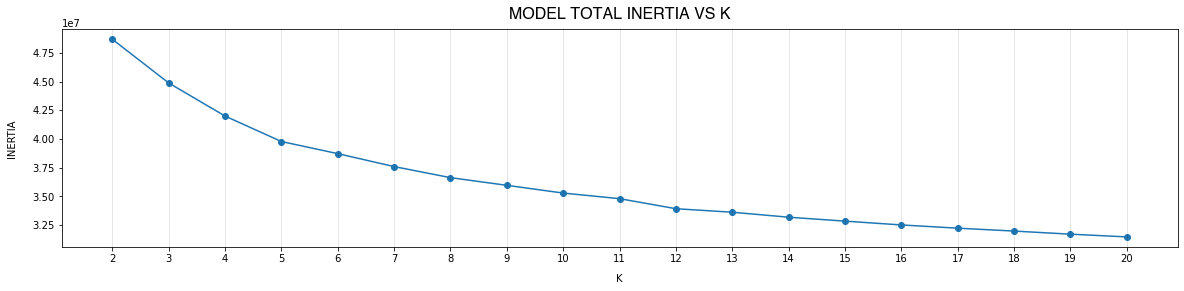

In [43]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(2, 21), inertias, marker='o')
ax.set_title('MODEL TOTAL INERTIA VS K', y=1.02, size=16, fontweight='bold', fontdict={'family': 'Helvetica'})
ax.set_xlabel('K', labelpad=10, size=10)
ax.set_ylabel('INERTIA', labelpad=15, size=10)
ax.set_xticks(range(2, 21))
for x in ax.get_xticks():
    ax.axvline(x, lw=1, color='k', alpha=0.1)
plt.show()

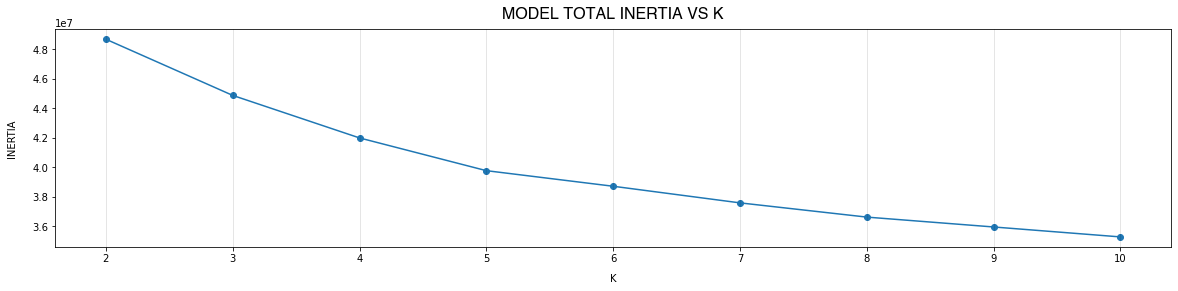

In [44]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(2, 11), inertias[:9], marker='o')
ax.set_title('MODEL TOTAL INERTIA VS K', y=1.02, size=16, fontweight='bold', fontdict={'family': 'Helvetica'})
ax.set_xlabel('K', labelpad=10, size=10)
ax.set_ylabel('INERTIA', labelpad=15, size=10)
ax.set_xticks(range(2, 11))
for x in ax.get_xticks():
    ax.axvline(x, lw=1, color='k', alpha=0.1)
plt.show()

As we can see, the choice is difficult, because the decrease is very smooth without strong _elbows_, but it seems that **K=5** could be a good choice here.  
Now that we have choosen K, we can build our final clustering model.

In [45]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(azdias_transformed)

KMeans(n_clusters=5)

In [47]:
azdias_clusters = kmeans.predict(azdias_transformed)

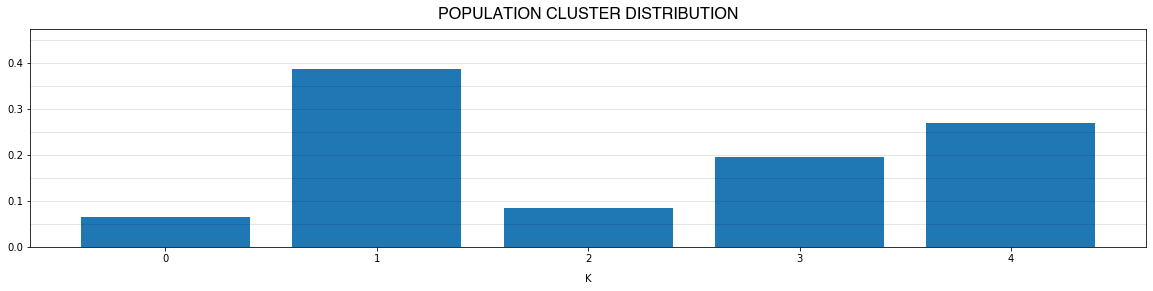

In [48]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.bar(range(5), pd.Series(azdias_clusters).value_counts(sort=False, normalize=True))
ax.set_title('POPULATION CLUSTER DISTRIBUTION', y=1.02, size=16, fontweight='bold', fontdict={'family': 'Helvetica'})
ax.set_xlabel('K', labelpad=10, size=10)
for y in ax.get_yticks():
    ax.axhline(y, lw=1, color='k', alpha=0.1)
plt.show()

## Customers

Now that we have labeled all the data in `azdias`, we want to undestand how the distribution of these groups differs from the entire population to the `customer` dataset.  
The over-represented classed in the customer dataset will be the best customer target for the company, and it should invest in campaigns targeted to them, in order to maximise the benefits over costs ratio.

In [52]:
# load customers dataset
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [53]:
# cleaning and preprocessing customers

# creating dummies
print('Cleaning Customers data')
customers_clean = step1_drop_and_dummies(customers)

# normalize the numeric features, to put all the features in the range [0, 1]
print('\nNormalizing data')
customers_clean.loc[:, numeric_vars] = (azdias.loc[:, numeric_vars].max() - azdias.loc[:, numeric_vars]) /\
                                       (azdias.loc[:, numeric_vars].max() - azdias.loc[:, numeric_vars].min())

# dropping columns
print('Dropping features')
for col in ['ANZ_HAUSHALTE_AKTIV',
            'ANZ_HH_TITEL',
            'KBA13_ANZAHL_PKW',
            'MIN_GEBAEUDEJAHR',
            'ANZ_HAUSHALTE_AKTIV',
            'ANZ_HH_TITEL',
            'ANZ_PERSONEN',
            'ANZ_TITEL',
            'KBA13_ANZAHL_PKW',
            'MIN_GEBAEUDEJAHR']:
    try:
        customers_clean.drop(col, axis=1, inplace=True)
    except:
        print(f'Feature {col} not found.')

# dropping every column whitch is not is azdias_reducted, because these featrues was not seen
# before and cannot be used by the models we created
customers_reducted = customers_clean.copy()
for col in customers_reducted.columns:
    if col not in features_keep:
        customers_reducted.drop(col, axis=1, inplace=True)
# on the countrary, we must create empty colums for every columns which is in azdias_reducted but not in customers_reducted (values not seen here when creating dummies)
for col in azdias_reducted:
    if col not in customers_reducted:
        customers_reducted[col] = 0

# sort the columns as the columns of azdias_reducted
customers_reducted = customers_reducted[azdias_reducted.columns]

# pca transformation
print('Applying PCA transformation')
customers_transformed = pca3.transform(customers_reducted)

# assiogning cluster groups
print('Assigning group labels')
customers_clusters = kmeans.predict(customers_transformed)

print('Finished!')

Cleaning Customers data
Feature "STATISTISCHE_HAUSHAL" not found in columns!

Original number of columns: 369
New number of columns: 2668

Normalizing data
Dropping features
Feature ANZ_HAUSHALTE_AKTIV not found.
Feature ANZ_HH_TITEL not found.
Feature KBA13_ANZAHL_PKW not found.
Feature MIN_GEBAEUDEJAHR not found.
Applying PCA transformation
Assigning group labels
Finished!


In [38]:
customers_reducted = customers_reducted[azdias_reducted.columns]

In [39]:
customers_transformed = pca3.transform(customers_reducted)

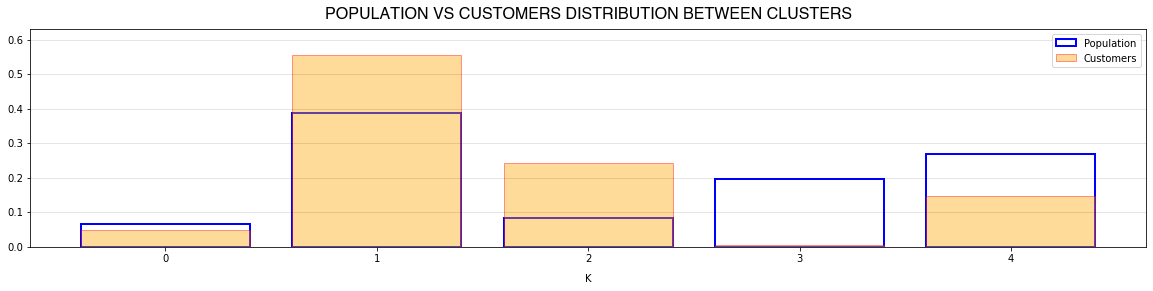

In [71]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.bar(range(5), pd.Series(azdias_clusters).value_counts(sort=False, normalize=True), fill=False, edgecolor='blue', linewidth=2, label='Population')
ax.bar(range(5), pd.Series(customers_clusters).value_counts(sort=False, normalize=True), color='orange', edgecolor='red', alpha=0.4, label='Customers')
ax.set_title('POPULATION VS CUSTOMERS DISTRIBUTION BETWEEN CLUSTERS', y=1.02, size=16, fontweight='bold', fontdict={'family': 'Helvetica'})
ax.set_xlabel('K', labelpad=10, size=10)
for y in ax.get_yticks():
    ax.axhline(y, lw=1, color='k', alpha=0.1)
ax.legend()
plt.show()

So, very interestingly we see here that the segments **1** and **2** are over-represented in the customer table, with respect to the population table, and so these are the target segments where invest in campaigns.  
We've discussed above that groups 1 and 2 seem also quite similar (for the first features known), let's try now to better undestand these two segments of people.

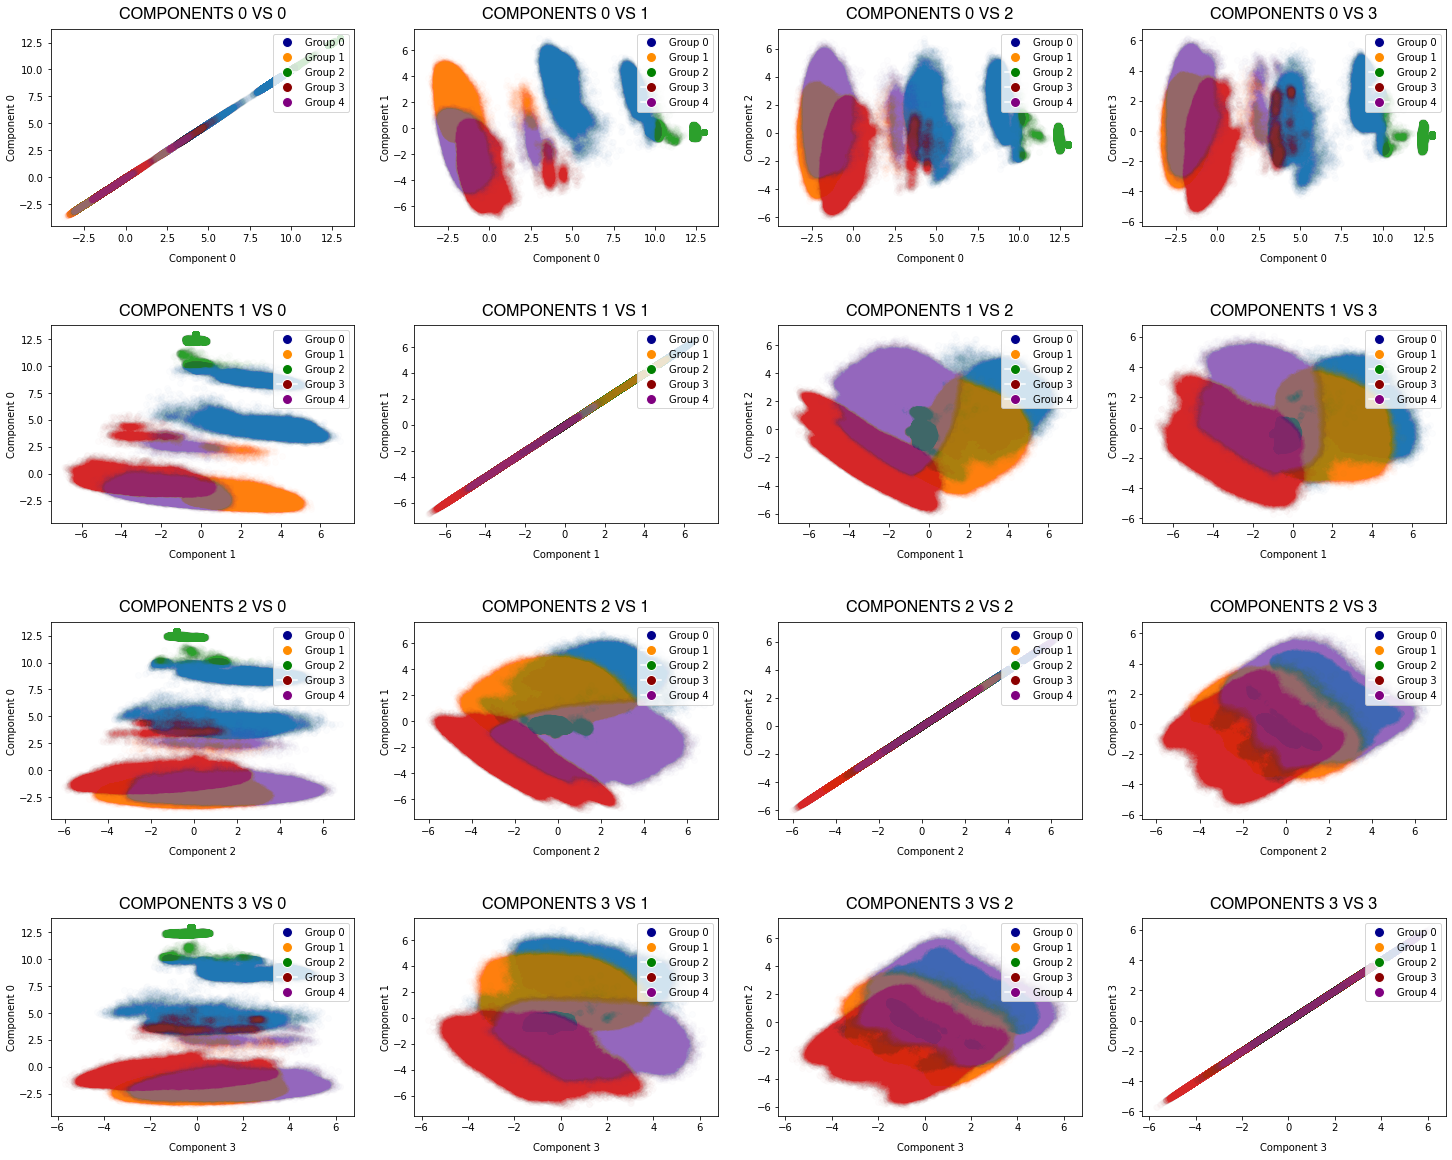

In [125]:
fig, ax = plt.subplots(4, 4, figsize=(25, 20), gridspec_kw={'hspace':0.5, 'wspace':0.2})
for i in range(4):
    for j in range(4):
        for group in range(5):
            ax[i, j].scatter(azdias_transformed[azdias_clusters==group, i], azdias_transformed[azdias_clusters==group, j], alpha=0.01, label=f'Group {group}')
        ax[i, j].set_title(f'COMPONENTS {i} VS {j}', y=1.02, size=16, fontweight='bold', fontdict={'family': 'Helvetica'})
        ax[i, j].set_xlabel(f'Component {i}', labelpad=10, size=10)
        ax[i, j].set_ylabel(f'Component {j}', labelpad=2, size=10)
        handles = [
            lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', ms=10),
            lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkorange', ms=10),
            lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', ms=10),
            lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', ms=10),
            lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', ms=10)
        ]
        ax[i, j].legend(handles, [f'Group {g}' for g in range(5)], loc=1)
plt.show()

The plot "Components 0 vs 1" (or vice-versa) is where we can see this two cluster as far as possible from each other, defyning their identity with the components which they are most correlated with.  

Below another possible reppresentation of the correlation between groups and principal components (on the y axis), focusing on just groups 1 and 2 and looking at the first 10 principal components. For every plot, we have on the x axis just the samples, while om the y axis the vaue for that component. If all or most of the obsarvations in a group are above zero, that component is positive correlated to that group, if intead all or most of the obsarvations are below zero, there is a negative correlation. The more distant from zero, the most strong the relationship.  
As you can see, it's cofirmed that only the components 0 and 1 are correlated with these two groups considerated.

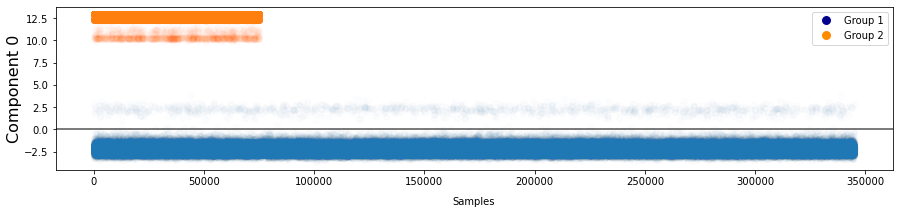

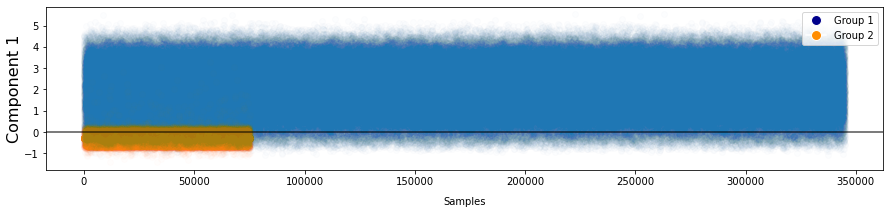

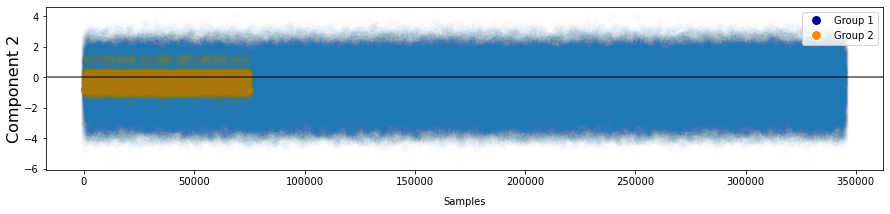

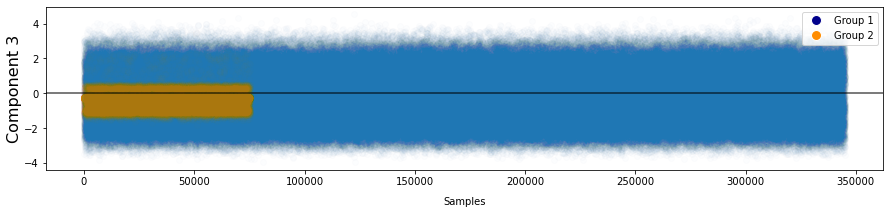

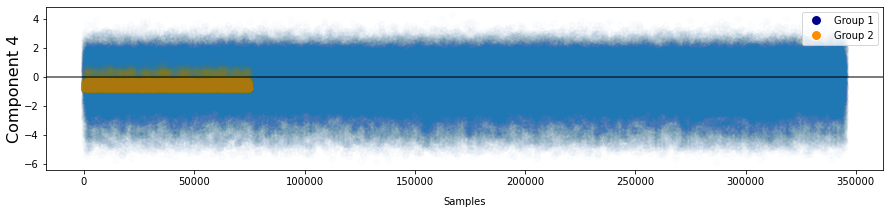

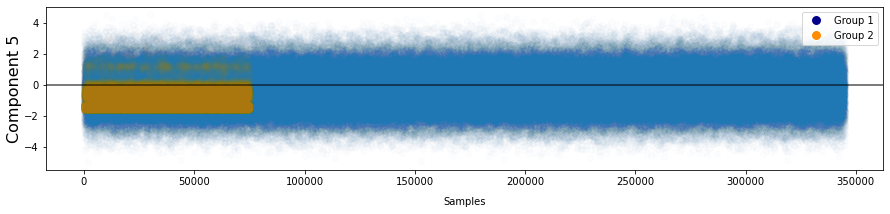

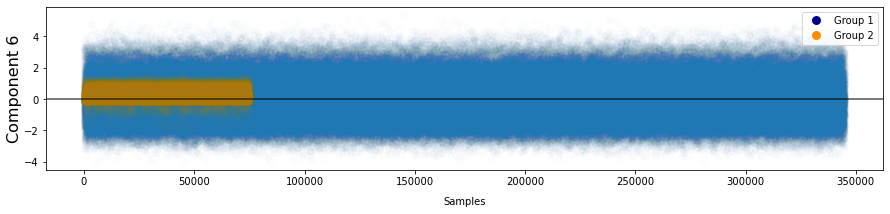

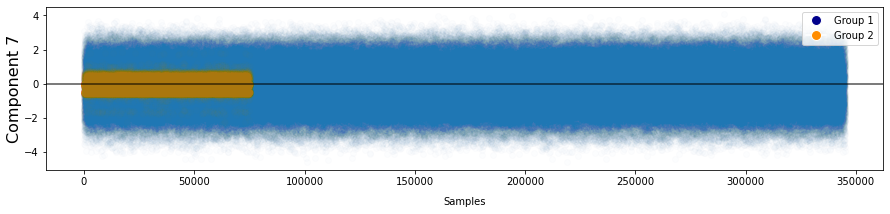

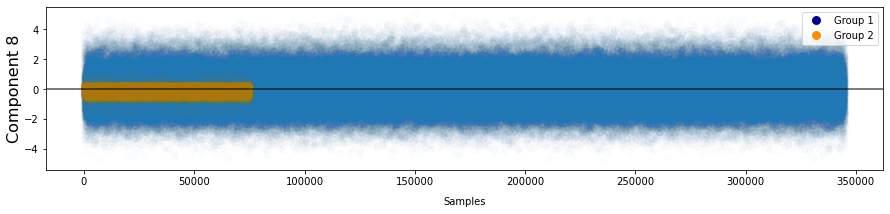

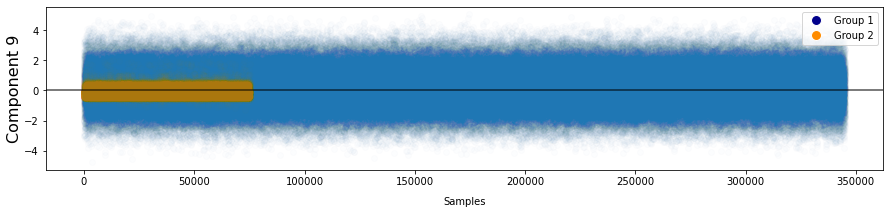

In [145]:
for comp in range(10):
    fig, ax = plt.subplots(figsize=(15, 3))
    for group in range(5):
        if group in [1, 2]:
            table = azdias_transformed[azdias_clusters==group, comp]
            ax.scatter(range(table.shape[0]), table, alpha=0.01, label=f'Group {group}')
            ax.axhline(0, color='k', lw=2, alpha=0.3)
    ax.set_xlabel(f'Samples', labelpad=10, size=10)
    ax.set_ylabel(f'Component {comp}', labelpad=2, size=16)
    handles = [
        lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', ms=10),
        lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkorange', ms=10)
    ]
    ax.legend(handles, ['Group 1', 'Group 2'], loc=1)
    plt.show()

From the two figures above, we can say that:
- Group 1:
    - negative collelation with Component 0
    - positive collelation with Component 1
<br><br>
- Group 2:
    - strong positive collelation with Component 0
    - weak negative collelation with Component 1
    - not clear collelation with Component 2
    - weak negative collelation (or no collelation) with Component 3
    - weak negative collelation with Component 4
    - weak negative collelation with Component 5
    - weak positive collelation (or no collelation) with Component 6

Let's recap the meaning of this two components, looking at the features they are most correlated to:

In [141]:
for i, comp in enumerate(pca3.components_[:5]):
    if i in [0, 1]:
        print(f'\nComponent {i}. Main features:')
        idxs = np.argsort(np.abs(comp))[::-1][:20]
        for idx in idxs:
            print(f'\t{azdias_reducted.columns[idx]} (coef: {np.round(comp[idx], 2)})')


Component 0. Main features:
	KBA05_ANTG1_nan (coef: 0.08)
	KBA05_HERST1_nan (coef: 0.08)
	KBA05_CCM2_nan (coef: 0.08)
	KBA05_KRSHERST3_nan (coef: 0.08)
	KBA05_MOD3_nan (coef: 0.08)
	KBA05_SEG9_nan (coef: 0.08)
	KBA05_SEG2_nan (coef: 0.08)
	KBA05_VORB1_nan (coef: 0.08)
	KBA05_HERST2_nan (coef: 0.08)
	KBA05_GBZ_nan (coef: 0.08)
	KBA05_SEG6_nan (coef: 0.08)
	KBA05_ALTER4_nan (coef: 0.08)
	KBA05_KW3_nan (coef: 0.08)
	MOBI_REGIO_nan (coef: 0.08)
	KBA05_MOD2_nan (coef: 0.08)
	KBA05_KRSHERST1_nan (coef: 0.08)
	KBA05_MAXSEG_nan (coef: 0.08)
	KBA05_ZUL1_nan (coef: 0.08)
	KBA05_KRSHERST2_nan (coef: 0.08)
	KBA05_ANTG3_nan (coef: 0.08)

Component 1. Main features:
	MOBI_RASTER_1.0 (coef: -0.12)
	D19_VERSAND_DATUM_10.0 (coef: -0.12)
	D19_GESAMT_ANZ_24_0.0 (coef: -0.12)
	D19_GESAMT_DATUM_10.0 (coef: -0.12)
	D19_GESAMT_ONLINE_DATUM_10.0 (coef: -0.11)
	LP_STATUS_GROB_1.0 (coef: -0.11)
	D19_VERSAND_ONLINE_DATUM_10.0 (coef: -0.11)
	D19_VERSAND_ANZ_24_0.0 (coef: -0.11)
	KBA13_BAUMAX_1.0 (coef: 0.11)
	KK

As we already saw before, the Component 0 is a component where most of _KBA05_ features are NAs (one should investigate when this occurs, to better undestand this segment).  
The Component 2 is , instaead, negatively joined to financial features, where they show "no transactions", and to age (still negatively), where it is 60 or higher.

Of course you could look at more principal components, and/or more features per component, to have a better undestanding of this groups.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [148]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Utente\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [152]:
print(mailout_train.shape)
print()
mailout_train.head()

(42962, 367)



,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [154]:
# response proportions
mailout_train.RESPONSE.value_counts(dropna=False, normalize=True)

0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64

We have here a very important unbalance between the two classes, too big to try oversampling methods and we haven't enought observations to try an undesampling method, so the approach we will use is to use model which can internally handle unbanced classes through the "class_weight" parameter, which gives at every sample a weight taht is inversely proportional to the importance of that class.

In [160]:
# just a check if the columns are the same as the previous tables
customers2 = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')
print(set(mailout_train.columns).difference(customers2.columns))
print(set(customers2.columns).difference(mailout_train.columns))
del customers2

{'RESPONSE'}
{'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'}


Now, if the structure is the same as the previous tables, we already know how to proceed to clean and preprocess the data.  
The only different is at the end of the pipeline, when here we don't want to use a clustering model, but a classification model. We will try some to choose the best.

In [170]:
# cleaning and preprocessing mailout

# splitting X and y
y = mailout_train.RESPONSE
X = mailout_train.drop('RESPONSE', axis=1)
# split this "train data" into sub train and test datasets, because we cannot work with the test test provided, that will be only the final step
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# creating dummies
print('Cleaning MAILOUT data')
X_train = step1_drop_and_dummies(X_train)
X_test = step1_drop_and_dummies(X_test)

# normalize the numeric features, to put all the features in the range [0, 1]
print('\nNormalizing data')
X_train.loc[:, numeric_vars] = (X_train.loc[:, numeric_vars].max() - X_train.loc[:, numeric_vars]) /\
                               (X_train.loc[:, numeric_vars].max() - X_train.loc[:, numeric_vars].min())
X_test.loc[:, numeric_vars] = (X_train.loc[:, numeric_vars].max() - X_test.loc[:, numeric_vars]) /\
                              (X_train.loc[:, numeric_vars].max() - X_train.loc[:, numeric_vars].min())

# dropping columns
print('Dropping features')
for col in ['ANZ_HAUSHALTE_AKTIV',
            'ANZ_HH_TITEL',
            'KBA13_ANZAHL_PKW',
            'MIN_GEBAEUDEJAHR',
            'ANZ_HAUSHALTE_AKTIV',
            'ANZ_HH_TITEL',
            'ANZ_PERSONEN',
            'ANZ_TITEL',
            'KBA13_ANZAHL_PKW',
            'MIN_GEBAEUDEJAHR']:
    try:
        X_train.drop(col, axis=1, inplace=True)
        X_test.drop(col, axis=1, inplace=True)
    except:
        print(f'Feature {col} not found.')

# dropping every column whitch is not is X_train from X_test, because these featrues was not seen
# before and cannot be used by the models we created
for col in X_test.columns:
    if col not in X_train:
        X_test.drop(col, axis=1, inplace=True)
# on the countrary, we must create empty colums for every columns which is in X_train but not in X_test (values not seen here when creating dummies)
for col in X_train:
    if col not in X_test:
        X_test[col] = 0

# sort the columns of X_test as the columns of X_train
X_test = X_test[X_train.columns]

print('Finished!')

Cleaning MAILOUT data
Feature "LNR" not found in columns!
Feature "STATISTISCHE_HAUSHAL" not found in columns!
Feature "D19_LETZTER_KAUF_BRANCHE" not found in columns!
Feature "EINGEFUEGT_AM" not found in columns!
Feature "EINGEZOGENAM_HH_JAHR" not found in columns!
Feature "EXTSEL992" not found in columns!
Feature "ALTERSKATEGORIE_FEIN" not found in columns!
Feature "VERDICHTUNGSRAUM" not found in columns!
Feature "ANZ_STATISTISCHE_HAUSHALTE" not found in columns!

Original number of columns: 358
New number of columns: 2653
Feature "LNR" not found in columns!
Feature "STATISTISCHE_HAUSHAL" not found in columns!
Feature "D19_LETZTER_KAUF_BRANCHE" not found in columns!
Feature "EINGEFUEGT_AM" not found in columns!
Feature "EINGEZOGENAM_HH_JAHR" not found in columns!
Feature "EXTSEL992" not found in columns!
Feature "ALTERSKATEGORIE_FEIN" not found in columns!
Feature "VERDICHTUNGSRAUM" not found in columns!
Feature "ANZ_STATISTISCHE_HAUSHALTE" not found in columns!

Original number of c

In [224]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [210]:
# function to print some model evaluation metrics

def model_results(model, X_train, X_test, y_train, y_test):
    """Print Precision, Recall and f1-score for both train and test set."""
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    print(f'TRAIN:   f1 = {f1_score(y_train, y_pred_train):.2f}' +
          f'   |   Precision = {precision_score(y_train, y_pred_train):.2f}' +
          f'   |   Recall = {recall_score(y_train, y_pred_train):.2f}')
    print(f'TEST:    f1 = {f1_score(y_test, y_pred_test):.2f}' +
          f'   |   Precision = {precision_score(y_test, y_pred_test):.2f}' +
          f'   |   Recall = {recall_score(y_test, y_pred_test):.2f}')

Let's try some classification models to see how they perform:

In [217]:
for model_name, model in {
    'Random Forest': RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_split=5, random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Support Vector Machine': SVC(class_weight='balanced')
}.items():

    pipeline = Pipeline([
        ('pca', PCA(n_components=50)),
        ('cls', model)
    ])

    pipeline.fit(X_train, y_train)

    print(f"Model: '{model_name}'")
    model_results(pipeline, X_train, X_test, y_train, y_test)
    print()

Model: 'Random Forest'
TRAIN:   f1 = 0.20   |   Precision = 0.12   |   Recall = 0.57
TEST:    f1 = 0.05   |   Precision = 0.04   |   Recall = 0.09

Model: 'Logistic Regression'
TRAIN:   f1 = 0.04   |   Precision = 0.02   |   Recall = 0.62
TEST:    f1 = 0.04   |   Precision = 0.02   |   Recall = 0.22

Model: 'AdaBoost'
TRAIN:   f1 = 0.00   |   Precision = 0.00   |   Recall = 0.00
TEST:    f1 = 0.00   |   Precision = 0.00   |   Recall = 0.00



C:\Users\Utente\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: 'Support Vector Machine'
TRAIN:   f1 = 0.26   |   Precision = 0.16   |   Recall = 0.87
TEST:    f1 = 0.04   |   Precision = 0.03   |   Recall = 0.09



In [218]:
for model_name, model in {
    'Random Forest': RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_split=5, random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Support Vector Machine': SVC(class_weight='balanced')
}.items():

    pipeline = Pipeline([
        ('pca', PCA(n_components=100)),
        ('cls', model)
    ])

    pipeline.fit(X_train, y_train)

    print(f"Model: '{model_name}'")
    model_results(pipeline, X_train, X_test, y_train, y_test)
    print()

Model: 'Random Forest'
TRAIN:   f1 = 0.46   |   Precision = 0.39   |   Recall = 0.57
TEST:    f1 = 0.01   |   Precision = 0.02   |   Recall = 0.01

Model: 'Logistic Regression'
TRAIN:   f1 = 0.05   |   Precision = 0.03   |   Recall = 0.66
TEST:    f1 = 0.06   |   Precision = 0.03   |   Recall = 0.24

Model: 'AdaBoost'
TRAIN:   f1 = 0.01   |   Precision = 0.50   |   Recall = 0.00
TEST:    f1 = 0.03   |   Precision = 0.01   |   Recall = 0.59

Model: 'Support Vector Machine'
TRAIN:   f1 = 0.48   |   Precision = 0.33   |   Recall = 0.87
TEST:    f1 = 0.03   |   Precision = 0.02   |   Recall = 0.03



In [219]:
for model_name, model in {
    'Random Forest': RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_split=5, random_state=42),
    #'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    #'AdaBoost': AdaBoostClassifier(random_state=42),
    #'Support Vector Machine': SVC(class_weight='balanced')
}.items():

    pipeline = Pipeline([
        ('pca', PCA(n_components=100)),
        ('cls', model)
    ])

    pipeline.fit(X_train, y_train)

In [220]:
pipeline.get_params()

{'memory': None,
 'steps': [('pca', PCA(n_components=100)),
  ('cls',
   RandomForestClassifier(class_weight='balanced', max_depth=5,
                          min_samples_split=5, random_state=42))],
 'verbose': False,
 'pca': PCA(n_components=100),
 'cls': RandomForestClassifier(class_weight='balanced', max_depth=5,
                        min_samples_split=5, random_state=42),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 100,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'cls__bootstrap': True,
 'cls__ccp_alpha': 0.0,
 'cls__class_weight': 'balanced',
 'cls__criterion': 'gini',
 'cls__max_depth': 5,
 'cls__max_features': 'auto',
 'cls__max_leaf_nodes': None,
 'cls__max_samples': None,
 'cls__min_impurity_decrease': 0.0,
 'cls__min_samples_leaf': 1,
 'cls__min_samples_split': 5,
 'cls__min_weight_fraction_leaf': 0.0,
 'cls__n_estimators': 100,
 'cls__n_jobs': None,
 'cls__oob_score': False,
 'cls__random

In [ ]:
RandomForestClassifier()

In [227]:
param_distributions = {
    'pca__n_components': [20, 50, 100, 150, 200],
    'cls__max_depth': list(range(2, 11)),
    'cls__min_samples_split': list(range(2, 22, 2)),
    'cls__min_samples_leaf': list(range(21))
}

cv_random_forest = RandomizedSearchCV(pipeline, param_distributions=param_distributions,scoring=f1_score, n_jobs=-1, verbose=3)
cv_random_forest.fit(X_train, y_train)

print(f"Model: 'Random Forest CV'")
model_results(cv_random_forest, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Utente\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Utente\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Utente\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Utente\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\Utente\anaconda3\lib

RandomizedSearchCV(estimator=Pipeline(steps=[('pca', PCA(n_components=100)),
                                             ('cls',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     max_depth=5,
                                                                     min_samples_split=5,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'cls__max_depth': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10],
                                        'cls__min_samples_leaf': [0, 1, 2, 3, 4,
                                                                  5, 6, 7, 8, 9,
                                                                  10, 11, 12,
                                                                  13, 14, 15,
                   

In [228]:
print(f"Model: 'Random Forest CV'")
model_results(cv_random_forest, X_train, X_test, y_train, y_test)

Model: 'Random Forest CV'
TRAIN:   f1 = 0.27   |   Precision = 0.17   |   Recall = 0.60
TEST:    f1 = 0.03   |   Precision = 0.02   |   Recall = 0.06


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')